In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np

# Load Data
file_path = '/content/drive/My Drive/credit_card_transactions.csv'
df = pd.read_csv(file_path)


In [ ]:

# Preprocessing
df['Name'] = df['first'] + '_' + df['last']
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
df['Year'] = df['trans_date_trans_time'].dt.year
df['Month'] = df['trans_date_trans_time'].dt.month
df['Day'] = df['trans_date_trans_time'].dt.day
df['Hour'] = df['trans_date_trans_time'].dt.hour
df['Min'] = df['trans_date_trans_time'].dt.minute
df['Sec'] = df['trans_date_trans_time'].dt.second

df.drop(columns=[
    'Unnamed: 0', 'trans_date_trans_time', 'first', 'last',
    'street', 'dob', 'trans_num', 'merch_zipcode',
    'city_pop', 'cc_num', 'zip'
], inplace=True, errors='ignore')


In [ ]:

# Encode categorical columns
cat_cols = ['merchant', 'category', 'state', 'job', 'gender', 'city']
for col in cat_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Standardize numerical columns
scaler = StandardScaler()
df[['amt', 'lat', 'long', 'merch_lat', 'merch_long']] = scaler.fit_transform(
    df[['amt', 'lat', 'long', 'merch_lat', 'merch_long']]
)


In [ ]:

# Graph (optional)
G = nx.MultiGraph()
G.add_nodes_from(df['Name'].unique(), type='customer')
G.add_nodes_from(df['merchant'].unique(), type='merchant')
for _, row in df.iterrows():
    G.add_edge(row['Name'], row['merchant'])

# Prepare data
features = df[[
    'Year', 'Month', 'Day', 'Hour', 'Min', 'Sec', 'amt',
    'gender', 'lat', 'long', 'merch_lat', 'merch_long',
    'category', 'state', 'job', 'city', 'unix_time'
]].values
labels = df['is_fraud'].values


In [ ]:

# SMOTE balancing
smote = SMOTE()
features_resampled, labels_resampled = smote.fit_resample(features, labels)
features_resampled = (features_resampled - features_resampled.mean(axis=0)) / features_resampled.std(axis=0)


In [ ]:

# Split
X_train, X_val, y_train, y_val = train_test_split(features_resampled, labels_resampled, test_size=0.2, random_state=42)

# Tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)


In [ ]:

# Enhanced MLP Model
class DeepFraudMLP(nn.Module):
    def __init__(self, input_dim, hidden_dims=[64, 32], dropout=0.4, activation='relu'):
        super(DeepFraudMLP, self).__init__()
        self.activation = F.relu if activation == 'relu' else torch.tanh
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.dropout(self.activation(self.fc1(x)))
        x = self.dropout(self.activation(self.fc2(x)))
        return self.fc3(x).squeeze(-1)

model = DeepFraudMLP(X_train.shape[1], hidden_dims=[64, 32], dropout=0.4, activation='relu')


In [ ]:

# Loss with class imbalance handling
pos_weight = torch.tensor([len(y_train) / y_train.sum()])
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

# Optimizer with L2 regularization (weight decay)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)

# Training loop with early stopping
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_val_loss = float('inf')
patience = 20
wait = 0


In [ ]:

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    logits = model(X_train)
    loss = criterion(logits, y_train)
    loss.backward()
    optimizer.step()

    preds = (torch.sigmoid(logits) > 0.5).float()
    acc = (preds == y_train).float().mean().item()

    model.eval()
    with torch.no_grad():
        val_logits = model(X_val)
        val_loss = criterion(val_logits, y_val)
        val_preds = (torch.sigmoid(val_logits) > 0.5).float()
        val_acc = (val_preds == y_val).float().mean().item()

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    train_accs.append(acc)
    val_accs.append(val_acc)

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Train Loss={loss.item():.4f}, Val Loss={val_loss.item():.4f}, Train Acc={acc:.4f}, Val Acc={val_acc:.4f}")

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        wait = 0
        torch.save(model.state_dict(), 'best_fraud_model.pth')
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# Load best model
model.load_state_dict(torch.load('best_fraud_model.pth'))

# Evaluation
model.eval()
with torch.no_grad():
    logits = model(X_val)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    cm = confusion_matrix(y_val.numpy(), preds.numpy())
    print("Confusion Matrix:\n", cm)

    fpr, tpr, _ = roc_curve(y_val.numpy(), probs.numpy())
    precision, recall, _ = precision_recall_curve(y_val.numpy(), probs.numpy())
    roc_auc = auc(fpr, tpr)


KeyboardInterrupt: 

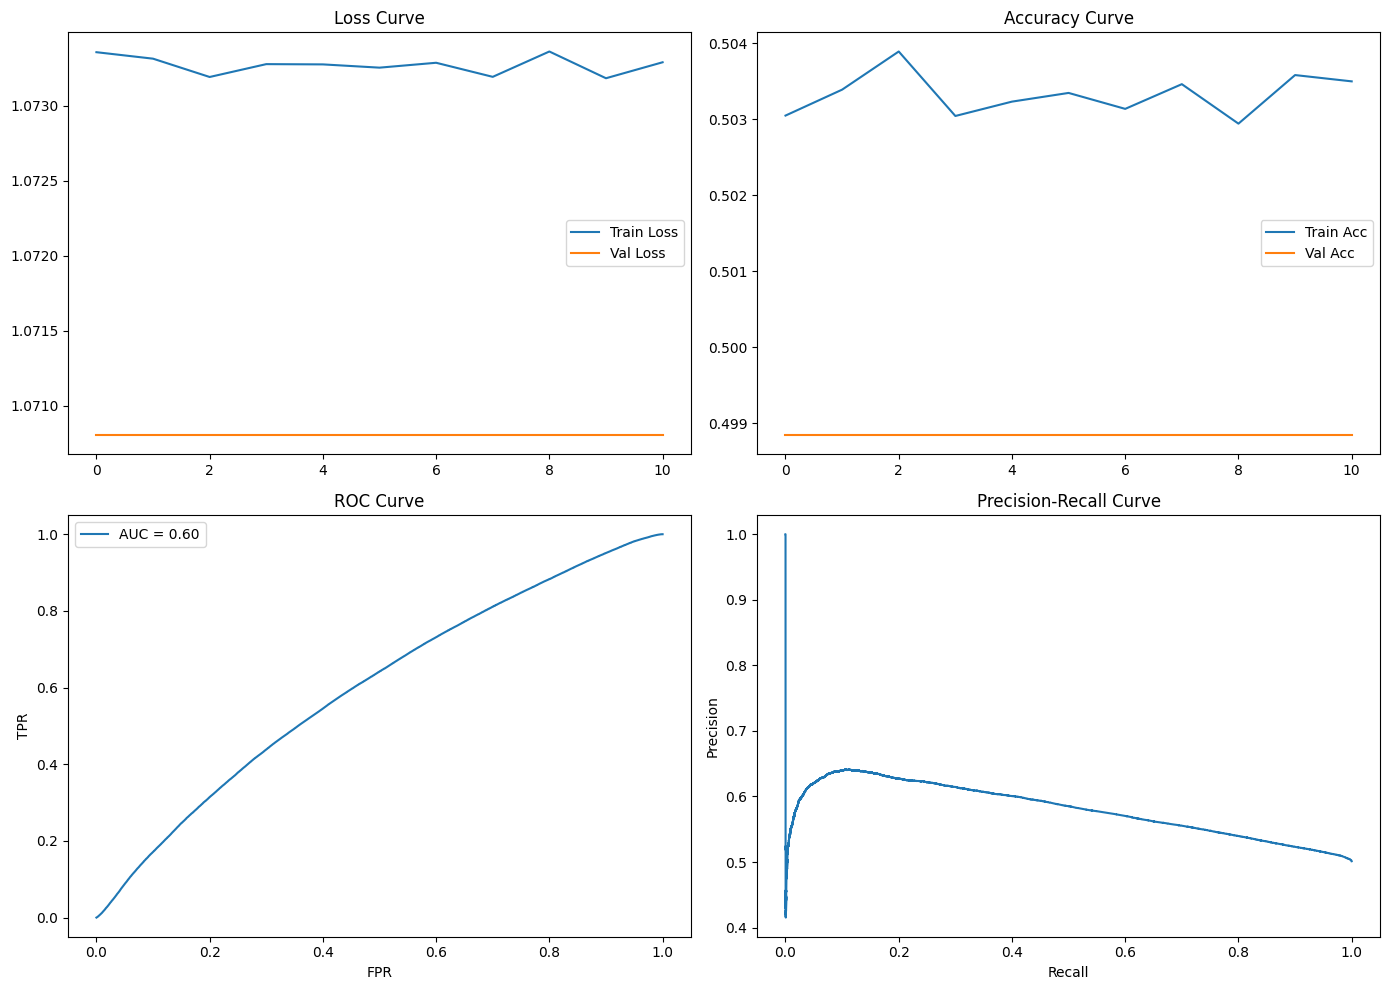

Best model saved to 'best_fraud_model.pth'


In [ ]:

# Plotting
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(2, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

print("Best model saved to 'best_fraud_model.pth'")


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
train_dataset = TensorDataset(X_train, y_train)
batch_size = 256  # Adjust based on your system's memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# Improved MLP with BatchNorm
class ImprovedMLP(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)


In [ ]:
train_losses, val_losses, train_accs, val_accs = [], [], [], []
best_f1 = 0
patience = 10
counter = 0

for epoch in range(50):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x).view(-1)
        loss = criterion(outputs, batch_y.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == batch_y).sum().item()
        total += batch_x.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val).view(-1)
        val_preds = (val_outputs > 0.5).float()
        val_loss = criterion(val_outputs, y_val.float()).item()
        val_acc = (val_preds == y_val).float().mean().item()
        val_f1 = f1_score(y_val, val_preds)

    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, F1 Score={val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "best_improved_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1: Train Loss=0.3855, Train Acc=0.8904, Val Loss=0.2939, Val Acc=0.9181, F1 Score=0.9162
Epoch 2: Train Loss=0.3152, Train Acc=0.9115, Val Loss=0.2613, Val Acc=0.9266, F1 Score=0.9246
Epoch 3: Train Loss=0.2932, Train Acc=0.9179, Val Loss=0.2461, Val Acc=0.9319, F1 Score=0.9297
Epoch 4: Train Loss=0.2826, Train Acc=0.9216, Val Loss=0.2375, Val Acc=0.9359, F1 Score=0.9344
Epoch 5: Train Loss=0.2758, Train Acc=0.9240, Val Loss=0.2309, Val Acc=0.9385, F1 Score=0.9372
Epoch 6: Train Loss=0.2692, Train Acc=0.9262, Val Loss=0.2238, Val Acc=0.9404, F1 Score=0.9387
Epoch 7: Train Loss=0.2628, Train Acc=0.9288, Val Loss=0.2172, Val Acc=0.9465, F1 Score=0.9453
Epoch 8: Train Loss=0.2577, Train Acc=0.9303, Val Loss=0.2109, Val Acc=0.9456, F1 Score=0.9446
Epoch 9: Train Loss=0.2538, Train Acc=0.9318, Val Loss=0.2031, Val Acc=0.9482, F1 Score=0.9472
Epoch 10: Train Loss=0.2509, Train Acc=0.9324, Val Loss=0.2002, Val Acc=0.9490, F1 Score=0.9481
Epoch 11: Train Loss=0.2494, Train Acc=0.9331, Va

In [ ]:
model.eval()
with torch.no_grad():
    logits = model(X_val)
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()

    cm = confusion_matrix(y_val.numpy(), preds.numpy())
    print("Confusion Matrix:\n", cm)

    fpr, tpr, _ = roc_curve(y_val.numpy(), probs.numpy())
    precision, recall, _ = precision_recall_curve(y_val.numpy(), probs.numpy())
    roc_auc = auc(fpr, tpr)

Confusion Matrix:
 [[241205  15981]
 [ 10134 248348]]


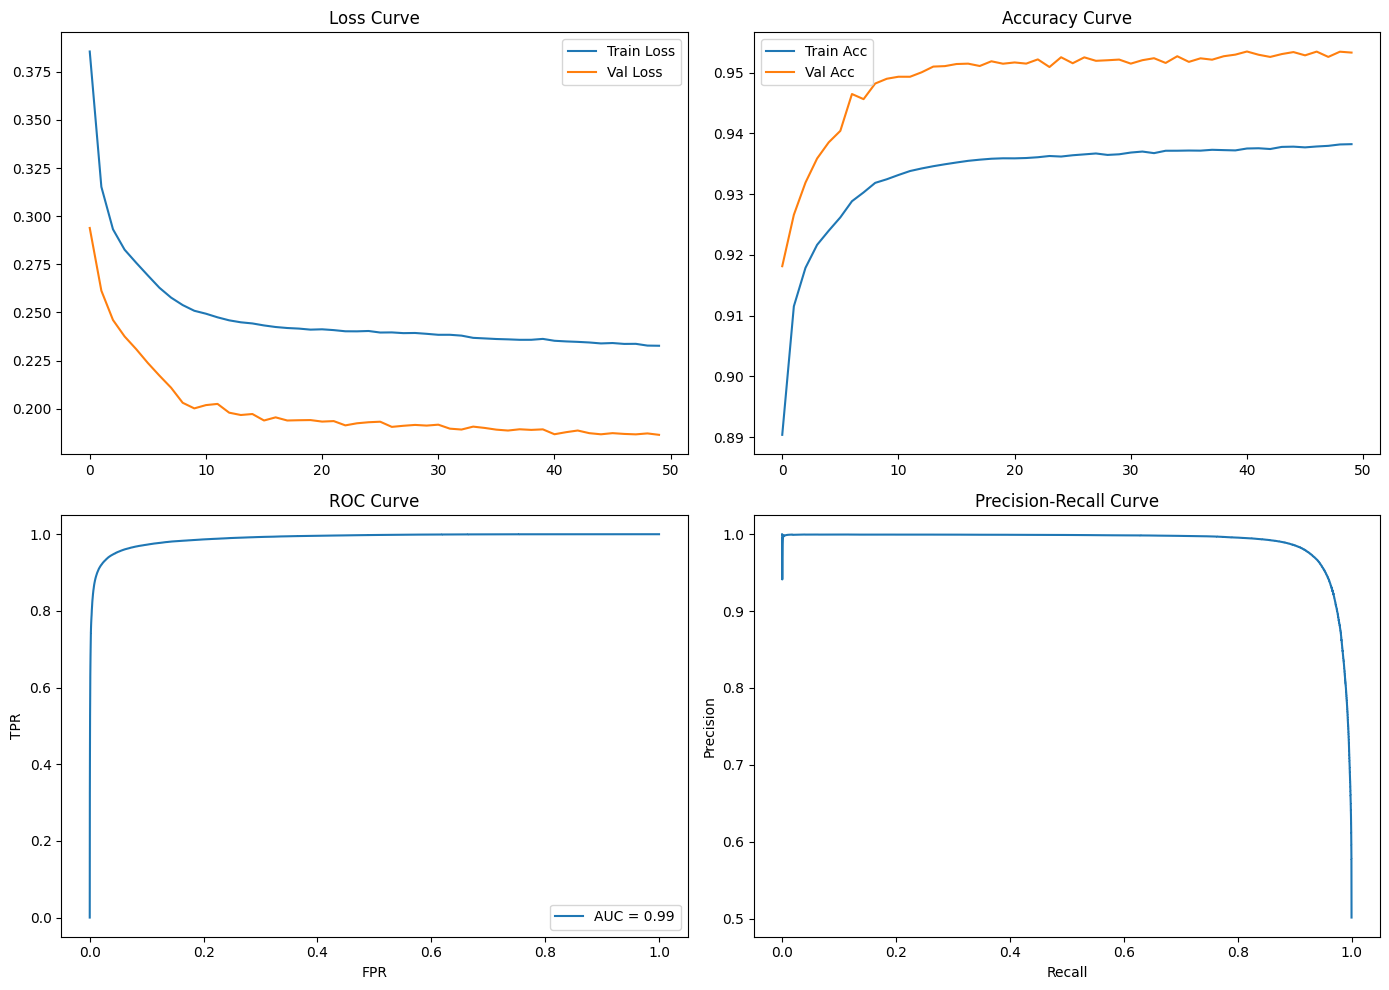

Best model saved to 'best_fraud_model.pth'


In [ ]:

# Plotting
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(2, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(2, 2, 3)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")

plt.tight_layout()
plt.show()

print("Best model saved to 'best_fraud_model.pth'")


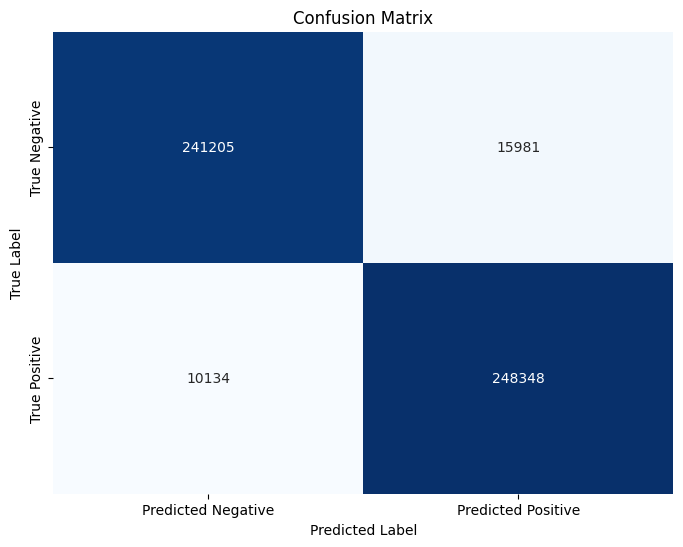

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming cm is your confusion matrix from the provided code
# cm = confusion_matrix(y_val.numpy(), preds.numpy())

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['True Negative', 'True Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()